# cTakes vs Metamap Concept Extraction Comparison

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

### Reading in data

#### Metamap

In [2]:
metamap = pd.read_csv("data/metamap_mappings.csv")
metamap["norm_file"] = metamap.file.apply(lambda x: x.split(".")[0])
metamap.head(3)

,file,cui,source,score,matched,preferred,matched_words,semantic_types,is_head,negated,norm_file
0,mtsamples-type-70-sample-110.txt.json,C0370003,SNOMEDCT_US,-645,Specimen,Specimen,['sample'],['sbst'],False,False,mtsamples-type-70-sample-110
1,mtsamples-type-70-sample-110.txt.json,C0332307,SNOMEDCT_US,-645,Type - attribute,Type - attribute,['type'],['qlco'],False,False,mtsamples-type-70-sample-110
2,mtsamples-type-70-sample-110.txt.json,C0037778,SNOMEDCT_US,-861,Medical speciality,Medical Specialities,"['medical', 'specialty']",['bmod'],True,False,mtsamples-type-70-sample-110


#### cTakes

In [3]:
ctakes = pd.read_csv("data/ctake_concepts.csv")
ctakes["norm_file"] = ctakes.file.apply(lambda x: x.split(".")[0])
ctakes = ctakes.rename(columns={"{http://www.omg.org/XMI}id": "id"})
ctakes.head(3)

,file,id,codingScheme,code,score,disambiguated,cui,tui,preferredText,norm_file
0,mtsamples-type-70-sample-1650.txt.xmi,8167,SNOMEDCT_US,322837006.0,0.0,False,C0355642,T121,Drugs used in migraine prophylaxis,mtsamples-type-70-sample-1650
1,mtsamples-type-70-sample-1650.txt.xmi,8210,SNOMEDCT_US,255631004.0,0.0,False,C0003232,T195,Antibiotics,mtsamples-type-70-sample-1650
2,mtsamples-type-70-sample-1650.txt.xmi,8901,SNOMEDCT_US,13924000.0,0.0,False,C0043250,T037,Injury wounds,mtsamples-type-70-sample-1650


#### Semantic Types

In [61]:
import requests

semantic_group_types_url = "https://lhncbc.nlm.nih.gov/ii/tools/MetaMap/Docs/SemGroups_2018.txt"
semantic_group_types_columns = ["abbrev", "name", "tui", "type_name"]

response = requests.get(semantic_group_types_url)
semantic_groups = pd.DataFrame(map(lambda x: x.split("|"), response.text.split("\n")), columns=semantic_group_types_columns)
semantic_groups = semantic_groups.iloc[:-1,:]
semantic_groups.head()

,abbrev,name,tui,type_name
0,ACTI,Activities & Behaviors,T052,Activity
1,ACTI,Activities & Behaviors,T053,Behavior
2,ACTI,Activities & Behaviors,T056,Daily or Recreational Activity
3,ACTI,Activities & Behaviors,T051,Event
4,ACTI,Activities & Behaviors,T064,Governmental or Regulatory Activity


In [62]:
semantic_types_url = "https://lhncbc.nlm.nih.gov/ii/tools/MetaMap/Docs/SemanticTypes_2018AB.txt"
semantic_types_columns = ["abbrev", "tui", "name"]

response = requests.get(semantic_types_url)
semantic_types = pd.DataFrame(map(lambda x: x.split("|"), response.text.split("\n")), columns=semantic_types_columns)
semantic_types = semantic_types.iloc[:-1,:]
semantic_types.head()

,abbrev,tui,name
0,aapp,T116,"Amino Acid, Peptide, or Protein"
1,acab,T020,Acquired Abnormality
2,acty,T052,Activity
3,aggp,T100,Age Group
4,amas,T087,Amino Acid Sequence


In [66]:
semantic_map = pd.merge(semantic_groups, semantic_types, on="tui", suffixes=["_group", "_type"])
semantic_map.head()

,abbrev_group,name_group,tui,type_name,abbrev_type,name_type
0,ACTI,Activities & Behaviors,T052,Activity,acty,Activity
1,ACTI,Activities & Behaviors,T053,Behavior,bhvr,Behavior
2,ACTI,Activities & Behaviors,T056,Daily or Recreational Activity,dora,Daily or Recreational Activity
3,ACTI,Activities & Behaviors,T051,Event,evnt,Event
4,ACTI,Activities & Behaviors,T064,Governmental or Regulatory Activity,gora,Governmental or Regulatory Activity


In [69]:
semantic_map.value_counts(["abbrev_group", "name_group"])

abbrev_group  name_group                 
LIVB          Living Beings                  21
CHEM          Chemicals & Drugs              20
CONC          Concepts & Ideas               12
DISO          Disorders                      12
ANAT          Anatomy                        11
ACTI          Activities & Behaviors          9
PHYS          Physiology                      9
PROC          Procedures                      7
PHEN          Phenomena                       6
GENE          Genes & Molecular Sequences     5
OBJC          Objects                         5
ORGA          Organizations                   4
DEVI          Devices                         3
OCCU          Occupations                     2
GEOG          Geographic Areas                1
Name: count, dtype: int64

In [70]:
metamap.semantic_types

0               ['sbst']
1               ['qlco']
2               ['bmod']
3               ['topp']
4               ['sbst']
              ...       
6878            ['qnco']
6879    ['orch', 'phsu']
6880            ['ftcn']
6881            ['qnco']
6882    ['orch', 'phsu']
Name: semantic_types, Length: 6883, dtype: object

## Analysis

### Typing Analysis

In [35]:
import re

def strlist_to_list(strlist: str) -> list:
    pattern = re.compile(r"\'(\w+)\'")
    return re.findall(pattern, strlist)

def map_upper(texts: list) -> str:
    upper_list = []

    for text in texts:
        upper_list.append(str(text).upper())
    return upper_list

All multi-types can be broken down into single groups.

In [90]:
meatmap_sems = list(map(strlist_to_list, metamap.semantic_types.unique()))
multi_meatmap_sems = list(filter(lambda x: len(x) > 1, meatmap_sems))

sems2 = []
for sems in multi_meatmap_sems:
    group = semantic_map.loc[semantic_map.abbrev_type.isin(['orch', 'phsu', 'vita']), "abbrev_group"].unique().tolist()
    sems2.append(
        (
            group,
            len(group),
            sems,
        )
    )

sems2

[(['CHEM'], 1, ['orch', 'phsu', 'vita']),
 (['CHEM'], 1, ['orch', 'phsu']),
 (['CHEM'], 1, ['horm', 'orch', 'phsu']),
 (['CHEM'], 1, ['hcro', 'mnob']),
 (['CHEM'], 1, ['bodm', 'orch']),
 (['CHEM'], 1, ['nnon', 'phsu']),
 (['CHEM'], 1, ['inch', 'phsu']),
 (['CHEM'], 1, ['tisu', 'topp']),
 (['CHEM'], 1, ['elii', 'hops']),
 (['CHEM'], 1, ['bacs', 'elii', 'phsu']),
 (['CHEM'], 1, ['antb', 'orch']),
 (['CHEM'], 1, ['aapp', 'antb']),
 (['CHEM'], 1, ['aapp', 'phsu']),
 (['CHEM'], 1, ['aapp', 'bacs', 'phsu']),
 (['CHEM'], 1, ['elii', 'phsu']),
 (['CHEM'], 1, ['aapp', 'imft'])]

In [103]:
semantic_map
metamap.semantic_types.apply(lambda x: strlist_to_list(x)[0]).to_frame()

,semantic_types
0,sbst
1,qlco
2,bmod
3,topp
4,sbst
...,...
6878,qnco
6879,orch
6880,ftcn
6881,qnco


In [109]:
metamap["tui"] = pd.merge(
    semantic_map.loc[:, ["abbrev_type", "tui"]],
    metamap.semantic_types.apply(lambda x: strlist_to_list(x)[0]).to_frame(),
    left_on="abbrev_type",
    right_on="semantic_types"
).tui
metamap.head()

,file,cui,source,score,matched,preferred,matched_words,semantic_types,is_head,negated,norm_file,tui
0,mtsamples-type-70-sample-110.txt.json,C0370003,SNOMEDCT_US,-645,Specimen,Specimen,['sample'],['sbst'],False,False,mtsamples-type-70-sample-110,T052
1,mtsamples-type-70-sample-110.txt.json,C0332307,SNOMEDCT_US,-645,Type - attribute,Type - attribute,['type'],['qlco'],False,False,mtsamples-type-70-sample-110,T052
2,mtsamples-type-70-sample-110.txt.json,C0037778,SNOMEDCT_US,-861,Medical speciality,Medical Specialities,"['medical', 'specialty']",['bmod'],True,False,mtsamples-type-70-sample-110,T052
3,mtsamples-type-70-sample-110.txt.json,C1318456,SNOMEDCT_US,-913,Cosmetic surgery,Cosmetic surgery,"['cosmetic', 'surgery']",['topp'],True,False,mtsamples-type-70-sample-110,T052
4,mtsamples-type-70-sample-110.txt.json,C0032167,SNOMEDCT_US,-827,"Plastic, NOS",Plastics,['plastic'],['sbst'],True,False,mtsamples-type-70-sample-110,T052


### Comparing CUI

In [92]:
ctakes_cui = set(ctakes.cui.unique())
metamap_cui = set(metamap.cui.unique())

print("There are %d unique CUI in ctakes." % len(ctakes_cui))
print("There are %d unique CUI in metamap." % len(metamap_cui))
print("There are %d unique CUI in both ctakes and metamap." % len(ctakes_cui.intersection(metamap_cui)))
print("There are %d unique ctakes CUI not in metamap." % len(ctakes_cui.difference(metamap_cui)))
print("There are %d unique metamap CUI not in ctakes." % len(metamap_cui.difference(ctakes_cui)))

There are 616 unique CUI in ctakes.
There are 1409 unique CUI in metamap.
There are 420 unique CUI in both ctakes and metamap.
There are 196 unique ctakes CUI not in metamap.
There are 989 unique metamap CUI not in ctakes.


In [9]:
file_cui_counts = pd.merge(
    left=ctakes.value_counts(merge_cols),
    right=metamap.value_counts(merge_cols),
    on=["norm_file", "cui"],
    suffixes=["_ctakes", "_metamap"]
)
file_cui_counts.head(3)

,,count_ctakes,count_metamap
norm_file,cui,,
mtsamples-type-70-sample-188,C0028429,46,2
mtsamples-type-70-sample-1365,C0018916,42,14
mtsamples-type-70-sample-109,C0037114,24,1


**CTAKES HAS MORE MENTIONS THAN METAMAP DUE TO ISSUE IN PARSING**

Need to seperate `PIs` into seperate instances.

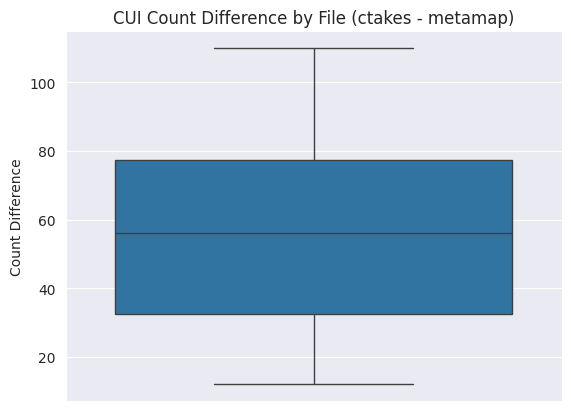

In [10]:
file_cui_counts["ctakes_minus_metamap"] = file_cui_counts.count_ctakes - file_cui_counts.count_metamap

diff_by_file = sns.boxplot(file_cui_counts.groupby("norm_file").ctakes_minus_metamap.sum().sort_values())
diff_by_file.set_title("CUI Count Difference by File (ctakes - metamap)")
diff_by_file.set_ylabel("Count Difference")

plt.show()

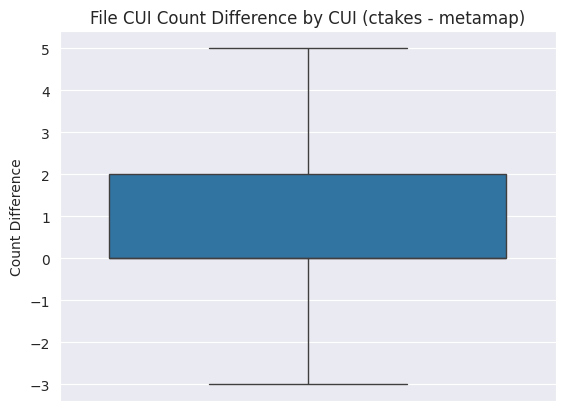

In [11]:
diff_by_file = sns.boxplot(file_cui_counts.groupby("cui").ctakes_minus_metamap.sum().sort_values(), showfliers=False)
diff_by_file.set_title("File CUI Count Difference by CUI (ctakes - metamap)")
diff_by_file.set_ylabel("Count Difference")

plt.show()